# Case: Previsão do preço de imóveis no Rio de Janeiro utilizando regressão

## Contexto
O mercado imobiliário é um importante setor da economia brasileira, e a previsão do preço de imóveis é uma questão relevante tanto para compradores quanto para vendedores. Neste caso, o objetivo é desenvolver um modelo de regressão para prever o preço de imóveis na cidade do Rio de Janeiro, utilizando dados públicos disponíveis.

## Base de dados
O Inside Airbnb (http://insideairbnb.com/get-the-data.html) oferece dados sobre anúncios de acomodações no Airbnb, incluindo informações sobre localização, tipo de imóvel, número de quartos e preços. É possível utilizar esses dados para modelar o preço dos imóveis no Rio de Janeiro, filtrando as informações relevantes para o contexto local.

## Aplicação de Ciência de Dados

### 1. Coleta e limpeza de dados
Baixe o arquivo "listings.csv" referente à cidade do Rio de Janeiro no Inside Airbnb. Em seguida, realize a limpeza dos dados removendo entradas duplicadas, tratando valores ausentes e convertendo variáveis categóricas em numéricas.
 - bronze: dado coletado em formato legivel (.parquet)
 - silver: dado filtrado ou convertido em formato (string -> date)
 - gold: dado do imóvel (id, preço, quantidade de quartos)

### 2. Análise exploratória de dados (EDA)
A EDA é realizada para identificar padrões, tendências e correlações entre as variáveis. Por exemplo, verificar a distribuição dos preços dos imóveis, identificar quais bairros possuem os imóveis mais caros e analisar a relação entre o tamanho do imóvel e o preço.

### 3. Feature engineering
Crie novas variáveis relevantes, como a distância até o centro da cidade ou a presença de comércio e serviços nas proximidades. Essas variáveis podem ajudar a melhorar o desempenho do modelo de regressão.

### 4. Modelagem e algoritmos
Separe a base de dados em conjuntos de treinamento e teste. Treine diferentes modelos de regressão, como regressão linear, árvores de decisão e regressão de floresta aleatória (Random Forest). Utilize validação cruzada para avaliar o desempenho dos modelos e selecione aquele com a melhor performance.

### 5. Avaliação e interpretação
Avalie o modelo selecionado utilizando métricas de desempenho, como o erro médio quadrático (RMSE) e o coeficiente de determinação (R²). Interprete os resultados, identificando os fatores que mais influenciam o preço dos imóveis e fornecendo insights para os interessados no mercado imobiliário.

Dessa forma, é possível criar um modelo de regressão para prever o preço de imóveis no Rio de Janeiro utilizando dados disponíveis e técnicas de ciência de dados.


#### Carregando os Dados

In [1]:
from google.colab import drive
import pandas as pd
import pyarrow.parquet as pq
import re
from geopy.distance import distance
import matplotlib.pyplot as plt


In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pd.set_option('display.max_columns', None)

In [4]:
mount_path = "/content/drive/MyDrive/Mentoria/Matheus Ogura/Ciência de Dados <> Carlos e Emanuel/Case 03 - Airbnb/"

In [5]:
# read the Parquet file into a pyarrow Table

listings = pq.read_table(mount_path + "data/bronze/listings.parquet")
neighbourhoods = pq.read_table(mount_path + "data/bronze/neighbourhoods.parquet")
reviews = pq.read_table(mount_path + "data/bronze/reviews.parquet")
calendar = pq.read_table(mount_path + "data/bronze/calendar.parquet")



In [6]:
# convert the pyarrow Table to a Pandas DataFrame

listings = listings.to_pandas()
neighbourhoods = neighbourhoods.to_pandas()
reviews = reviews.to_pandas()
calendar = calendar.to_pandas()

In [7]:
df=listings
df['price'] = df['price'].str.replace('[$,]', '', regex=True).astype(float)

In [9]:
# Arrumando as colunas Price, Bathrooms_text

# listings['price'] = listings['price'].str.replace('[$,]', '', regex=True).astype(float)
listings['bathrooms_text'] = listings['bathrooms_text'].astype(str)

<Axes: xlabel='room_type,bedrooms'>

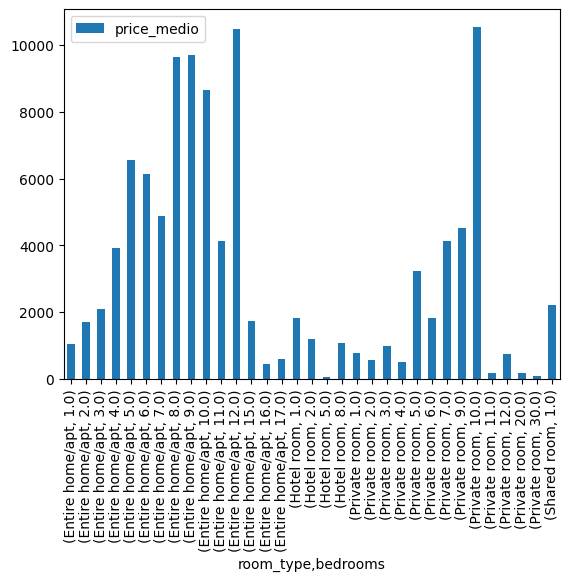

In [10]:
listings.groupby(['room_type','bedrooms']).agg(price_medio=('price','mean')).plot.bar()

In [11]:

listings.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,2.830100e+04,2.830100e+04,2.830100e+04,28298.000000,28298.000000,0.0,28301.000000,28301.000000,28301.000000,0.0,27014.000000,28079.000000,28301.000000,28301.000000,28301.000000,28301.000000,28301.000000,28301.000000,28301.000000,28301.000000,28301.000000,0.0,28301.000000,28301.000000,28301.000000,28301.000000,28301.000000,28301.000000,28301.000000,19783.000000,19601.000000,19602.000000,19602.000000,19601.000000,19600.000000,19601.000000,0.0,28301.000000,28301.000000,28301.000000,28301.000000,19783.000000
mean,2.226960e+17,2.022123e+13,1.457719e+08,19.797901,30.847410,NaN,-22.967609,-43.250871,4.114024,NaN,1.677130,2.557071,1448.447369,4.904138,528.441751,4.543550,5.711565,629.325784,671.281333,4.821109,657.905876,NaN,14.453270,31.777852,53.365853,207.147168,17.502420,6.156673,0.398466,4.730644,4.802830,4.721006,4.880358,4.863260,4.869042,4.689421,NaN,9.448677,8.675029,0.680718,0.081517,0.894104
std,3.274209e+17,0.000000e+00,1.530791e+08,105.382449,142.808883,NaN,0.034977,0.099639,2.382022,NaN,1.005444,2.151025,9631.935666,24.675970,551.920258,21.298064,25.031511,566.884637,558.971637,21.472801,558.121162,NaN,11.458966,21.865186,31.350048,136.190680,37.786946,10.662293,0.930661,0.616910,0.412908,0.472404,0.339916,0.366485,0.323033,0.455952,NaN,27.668056,27.675389,1.736604,0.684171,1.026587
min,1.787800e+04,2.022123e+13,3.607000e+03,1.000000,1.000000,NaN,-23.072840,-43.705910,0.000000,NaN,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,NaN,1.000000,0.000000,0.000000,0.000000,0.010000
25%,1.583170e+07,2.022123e+13,1.745770e+07,1.000000,1.000000,NaN,-22.984820,-43.309340,2.000000,NaN,1.000000,1.000000,317.000000,1.000000,45.000000,1.000000,2.000000,90.000000,90.000000,2.000000,90.000000,NaN,2.000000,10.000000,28.000000,76.000000,0.000000,0.000000,0.000000,4.710000,4.780000,4.640000,4.890000,4.870000,4.870000,4.600000,NaN,1.000000,1.000000,0.000000,0.000000,0.190000
50%,4.432035e+07,2.022123e+13,7.844898e+07,2.000000,3.000000,NaN,-22.972995,-43.196190,4.000000,NaN,1.000000,2.000000,600.000000,2.000000,365.000000,2.000000,3.000000,365.000000,1125.000000,2.300000,999.000000,NaN,14.000000,34.000000,60.000000,223.000000,3.000000,1.000000,0.000000,4.910000,4.940000,4.880000,5.000000,5.000000,5.000000,4.800000,NaN,2.000000,1.000000,0.000000,0.000000,0.540000
75%,6.340560e+17,2.022123e+13,2.447420e+08,5.000000,7.000000,NaN,-22.956210,-43.186255,5.000000,NaN,2.000000,3.000000,1071.000000,4.000000,1125.000000,3.000000,5.000000,1125.000000,1125.000000,4.000000,1125.000000,NaN,26.000000,53.000000,83.000000,350.000000,16.000000,7.000000,0.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,NaN,4.000000,3.000000,1.000000,0.000000,1.240000
max,7.915838e+17,2.022123e+13,4.930385e+08,1821.000000,1849.000000,NaN,-22.749690,-43.104400,16.000000,NaN,30.000000,91.000000,604981.000000,1125.000000,47036.000000,1125.000000,1125.000000,47036.000000,47036.000000,1125.000000,47036.000000,NaN,30.000000,60.000000,90.000000,365.000000,563.000000,174.

In [12]:
#Arrumando os números de banheiros
listings['bathrooms']=listings['bathrooms_text'].str.extract(r'(\d+(?:\.\d+)?)?').astype(float)

In [13]:
# coordenadas do RJ centro
point=(-22.9071,-43.1819)

#Definindo uma função para calculo da distancia

def calc_distance(row):
    coords = (row['latitude'], row['longitude'])
    return distance(point, coords).km



In [14]:
#aplicando a distancia do centro do RJ
listings['distance'] = listings.apply(calc_distance, axis=1)


In [15]:
listings.head(3)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,distance
0,783493769216852616,https://www.airbnb.com/rooms/783493769216852616,20221229002515,2022-12-29,city scrape,"Leme, Brasil",Apartamento aconchegante próximo à praia do Le...,None,https://a0.muscache.com/pictures/fe1f4b1b-a300...,491704706,https://www.airbnb.com/users/show/491704706,Felipe,2022-12-16,None,None,within a few hours,100%,67%,f,https://a0.muscache.com/defaults/user_pic-50x5...,https://a0.muscache.com/defaults/user_pic-225x...,Leme,2.0,2.0,"['email', 'phone']",f,f,None,Leme,NaN,-22.96421,-43.171600,Entire rental unit,Entire home/apt,2,1.0,1 bath,1.0,1.0,"[""Wifi"", ""Dedicated workspace"", ""Kitchen"", ""Fi...",720.0,1,365,1,1,365,365,1.0,365.0,NaN,t,27,57,87,362,2022-12-29,0,0,0,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,2,2,0,0,NaN,6.412172
1,703973293620197060,https://www.airbnb.com/rooms/703973293620197060,20221229002515,2022-12-29,city scrape,Suíte com entrada independente em casarão 1,"Casa ampla, em excelente localização, situada ...",None,https://a0.muscache.com/pictures/miso/Hosting-...,20362236,https://www.airbnb.com/users/show/20362236,Júlio Cesar,2014-08-21,"Rio de Janeiro, Brazil",None,within an hour,70%,100%,f,https://a0.muscache.com/im/users/20362236/prof...,https://a0.muscache.com/im/users/20362236/prof...,Botafogo,4.0,5.0,"['email', 'phone']",t,t,None,Botafogo,NaN,-22.95792,-43.182226,Private room in bed and breakfast,Private room,2,1.0,1 private bath,1.0,1.0,"[""Wifi"", ""Lock on bedroom door"", ""TV"", ""Coffee...",599.0,4,365,4,4,365,365,4.0,365.0,NaN,t,28,58,88,363,2022-12-29,1,1,0,2022-09-06,2022-09-06,5.0,5.0,5.0,5.0,5.0,4.0,5.0,NaN,t,4,0,4,0,0.26,5.628063
2,782895997622988215,https://www.airbnb.com/rooms/782895997622988215,20221229002515,2022-12-29,city scrape,Apartamento próximo ao metrô,Sua família vai estar perto de tudo ao ficar n...,None,https://a0.muscache.com/pictures/d48a6798-d1c8...,302417043,https://www.airbnb.com/users/show/302417043,Laís,2019-10-14,"Rio de Janeiro, Brazil",None,within a few hours,100%,50%,f,https://a0.muscache.com/im/pictures/user/fadcf...,https://a0.muscache.com/im/pictures/user/fadcf...,Laranjeiras,1.0,1.0,"['email', 'phone']",t,t,None,Laranjeiras,NaN,-22.93196,-43.180180,Entire rental unit,Entire home/apt,4,1.0,1 bath,2.0,1.0,"[""Cooking basics"", ""Clothing storage"", ""Washer...",240.0,3,365,3,3,365,365,3.0,365.0,NaN,t,19,40,70,160,2022-12-29,0,0,0,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,1,1,0,0,NaN,2.758716


<Axes: xlabel='room_type,bedrooms'>

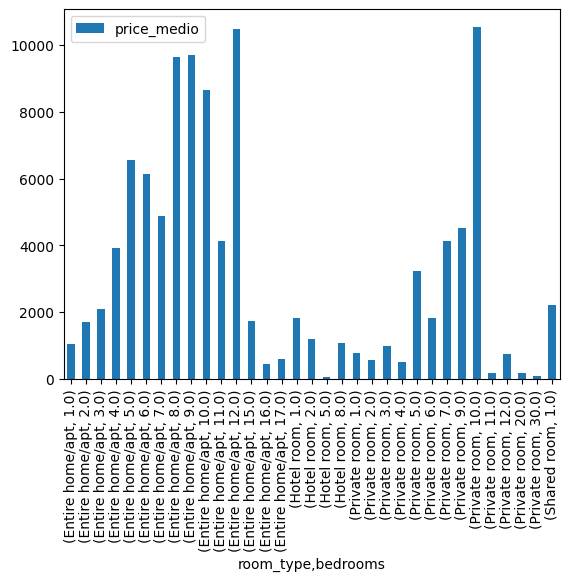

In [16]:
listings.groupby(['room_type','bedrooms']).agg(price_medio=('price','mean')).plot.bar()

<Axes: xlabel='bathrooms'>

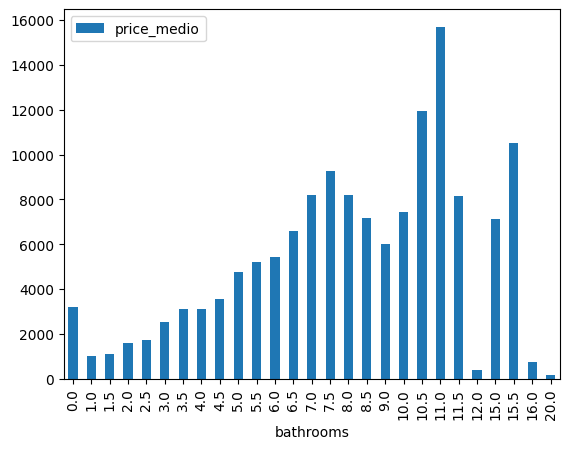

In [17]:
listings.groupby(['bathrooms']).agg(price_medio=('price','mean')).plot.bar()

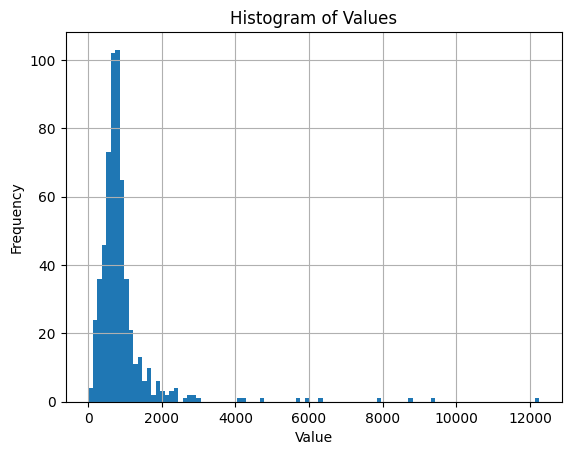

In [18]:
listings.groupby(['reviews_per_month']).agg(price_medio=('price','mean')).hist(bins=100)
plt.title('Histogram of Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [19]:
plt.show()